# 13.3f: Stripe Hunter — Raw Pairwise Distance Scatter

**Goal:** Do pairwise L∞ distances fall on discrete horizontal stripes (quantization) or continuous cloud?

## The Question

Initialize 151,936 tokens in f32 → quantize ALL to bf16 → sample 2,221 survivors → compute pairwise L∞.

**Then plot them raw.**

- **Horizontal stripes** at multiples of 6e-5 → ice hypercube ✓
- **Continuous cloud** → snow hyperball

No histograms. No aggregation. Just scatter.

## Parameters

In [1]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Monument Valley parameters
N_TOTAL_TOKENS = 151936
N_SURVIVORS = 2221
N_DIMS = 2560

# Single trial parameters
SIGMA = 5e-6  # The fully connected regime

# Chunked computation (stay under 24GB)
CHUNK_SIZE = 300

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Imports complete")

Using device: mps
✓ Imports complete


## Load Centroid

In [3]:
data = load_file(DEAD_TOKENS_PATH)
qwen_centroid = data['weighted_centroid'].to(device)

print(f"✓ Loaded centroid (norm = {torch.norm(qwen_centroid, p=2).item():.6f})")

✓ Loaded centroid (norm = 0.370917)


## Generate Monument Valley Sample

In [4]:
print(f"\nGenerating Monument Valley sample with σ = {SIGMA:.2e}\n")

# 1. Initialize in f32
init_f32 = qwen_centroid + torch.randn(N_TOTAL_TOKENS, N_DIMS, device=device) * SIGMA
print("✓ Initialized f32 tokens")

# 2. Quantize ALL to bf16
init_bf16 = init_f32.to(torch.bfloat16)
print("✓ Quantized to bfloat16")

# 3. Sample survivors
survivor_indices = torch.randperm(N_TOTAL_TOKENS, device=device)[:N_SURVIVORS]
survivors = init_bf16[survivor_indices].to(torch.float32)
print(f"✓ Sampled {N_SURVIVORS} survivors")

del init_f32, init_bf16  # Free memory


Generating Monument Valley sample with σ = 5.00e-06

✓ Initialized f32 tokens
✓ Quantized to bfloat16
✓ Sampled 2221 survivors


## Compute Pairwise L∞ Distances

In [5]:
print("\nComputing pairwise L∞ distances...\n")

n = len(survivors)
linf_distances = []

for i in range(0, n, CHUNK_SIZE):
    chunk = survivors[i:i+CHUNK_SIZE]
    diff = torch.abs(chunk.unsqueeze(1) - survivors.unsqueeze(0))
    linf = torch.max(diff, dim=2)[0]
    linf_distances.append(linf)
    
    if (i // CHUNK_SIZE) % 3 == 0:
        print(f"  Chunk {i//CHUNK_SIZE + 1}/{(n + CHUNK_SIZE - 1)//CHUNK_SIZE}")

linf_matrix = torch.cat(linf_distances, dim=0)
print("\n✓ L∞ matrix complete")

# Extract upper triangle
upper_tri_indices = torch.triu_indices(n, n, offset=1)
pairwise_linf = linf_matrix[upper_tri_indices[0], upper_tri_indices[1]].cpu().numpy()

print(f"\nPairwise distances: {len(pairwise_linf):,}")
print(f"Min: {pairwise_linf.min():.6e}")
print(f"Max: {pairwise_linf.max():.6e}")
print(f"Mean: {pairwise_linf.mean():.6e}")


Computing pairwise L∞ distances...

  Chunk 1/8
  Chunk 4/8
  Chunk 7/8

✓ L∞ matrix complete

Pairwise distances: 2,465,310
Min: 1.907349e-05
Max: 6.103516e-05
Mean: 3.062058e-05


## STRIPE SCATTER: The Moment of Truth

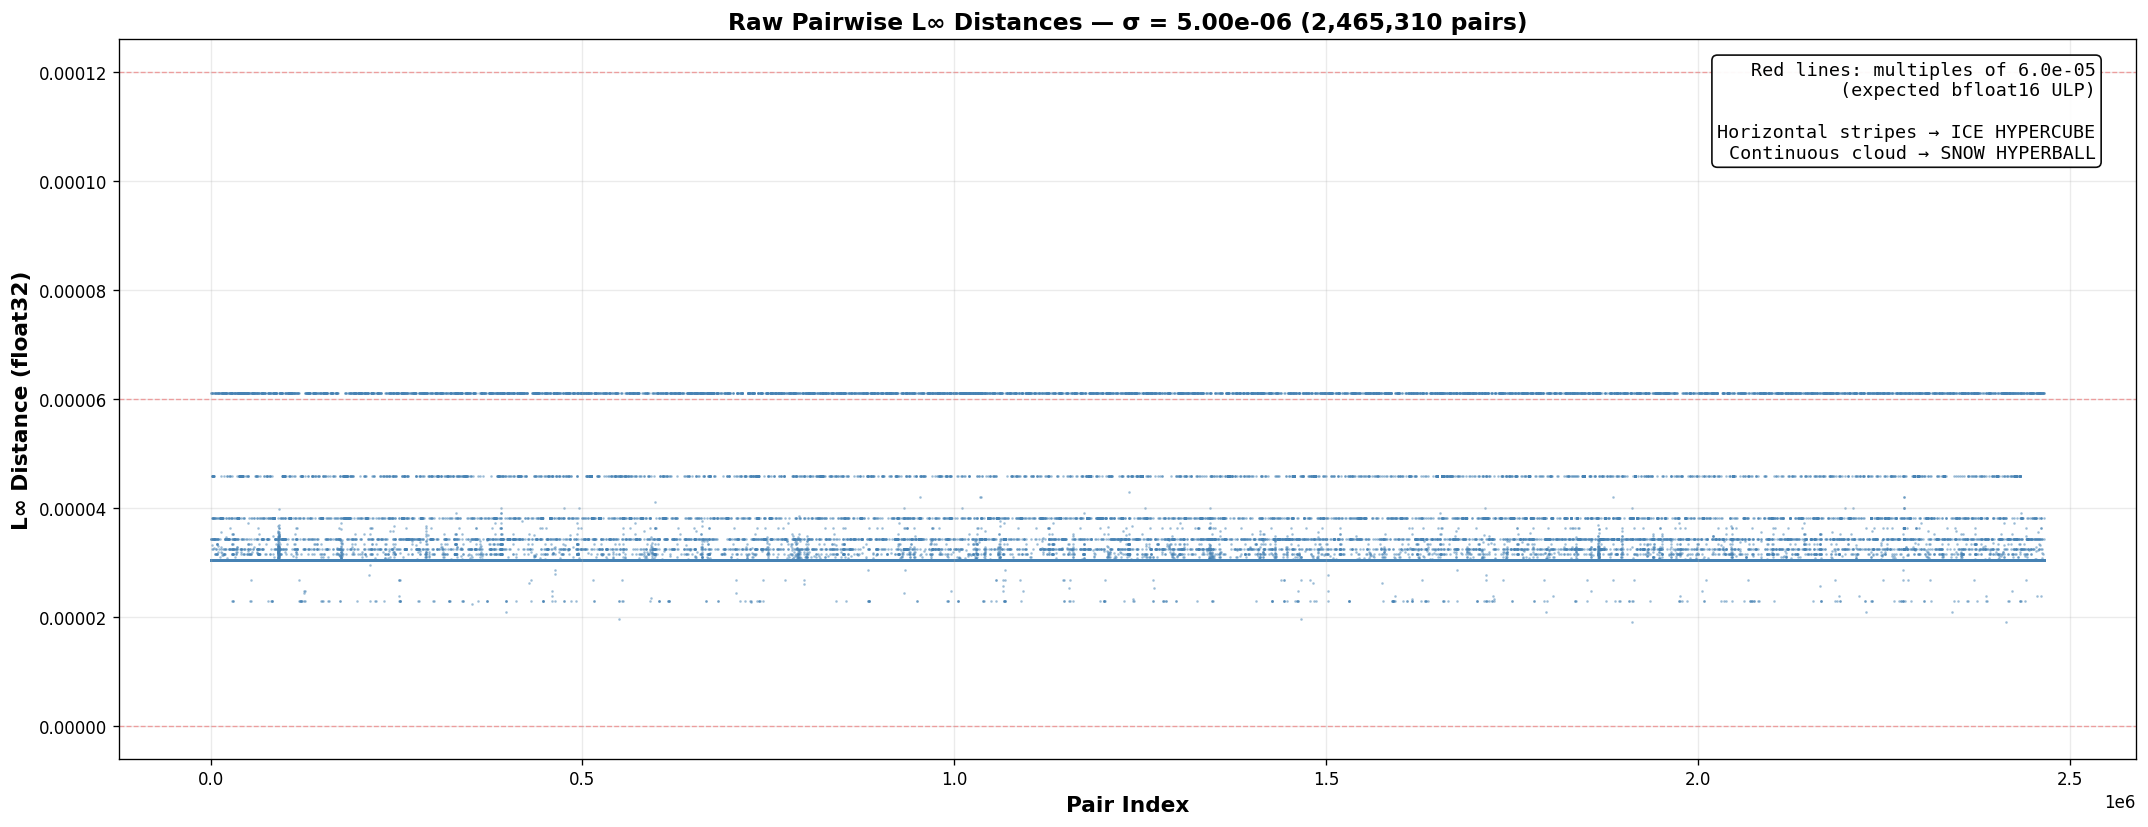


✓ Scatter plot complete


In [6]:
fig, ax = plt.subplots(figsize=(18, 7), dpi=120)

# Scatter all pairwise distances
x_indices = np.arange(len(pairwise_linf))
ax.scatter(x_indices, pairwise_linf, s=0.3, alpha=0.5, color='steelblue', rasterized=True)

# Mark multiples of 6e-5 with horizontal red lines
ulp = 6e-5
y_max = pairwise_linf.max()
for mult in range(0, int(y_max / ulp) + 2):
    ax.axhline(mult * ulp, color='red', linestyle='--', alpha=0.4, linewidth=0.8, zorder=1)

ax.set_xlabel('Pair Index', fontsize=13, fontweight='bold')
ax.set_ylabel('L∞ Distance (float32)', fontsize=13, fontweight='bold')
ax.set_title(f'Raw Pairwise L∞ Distances — σ = {SIGMA:.2e} ({len(pairwise_linf):,} pairs)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.25)

# Legend box
ax.text(0.98, 0.97, 
        f'Red lines: multiples of {ulp:.1e}\n(expected bfloat16 ULP)\n\n'
        'Horizontal stripes → ICE HYPERCUBE\n'
        'Continuous cloud → SNOW HYPERBALL', 
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='black'),
        fontsize=11, family='monospace')

plt.tight_layout()
plt.show()

print("\n✓ Scatter plot complete")

## Zoomed View (if needed)

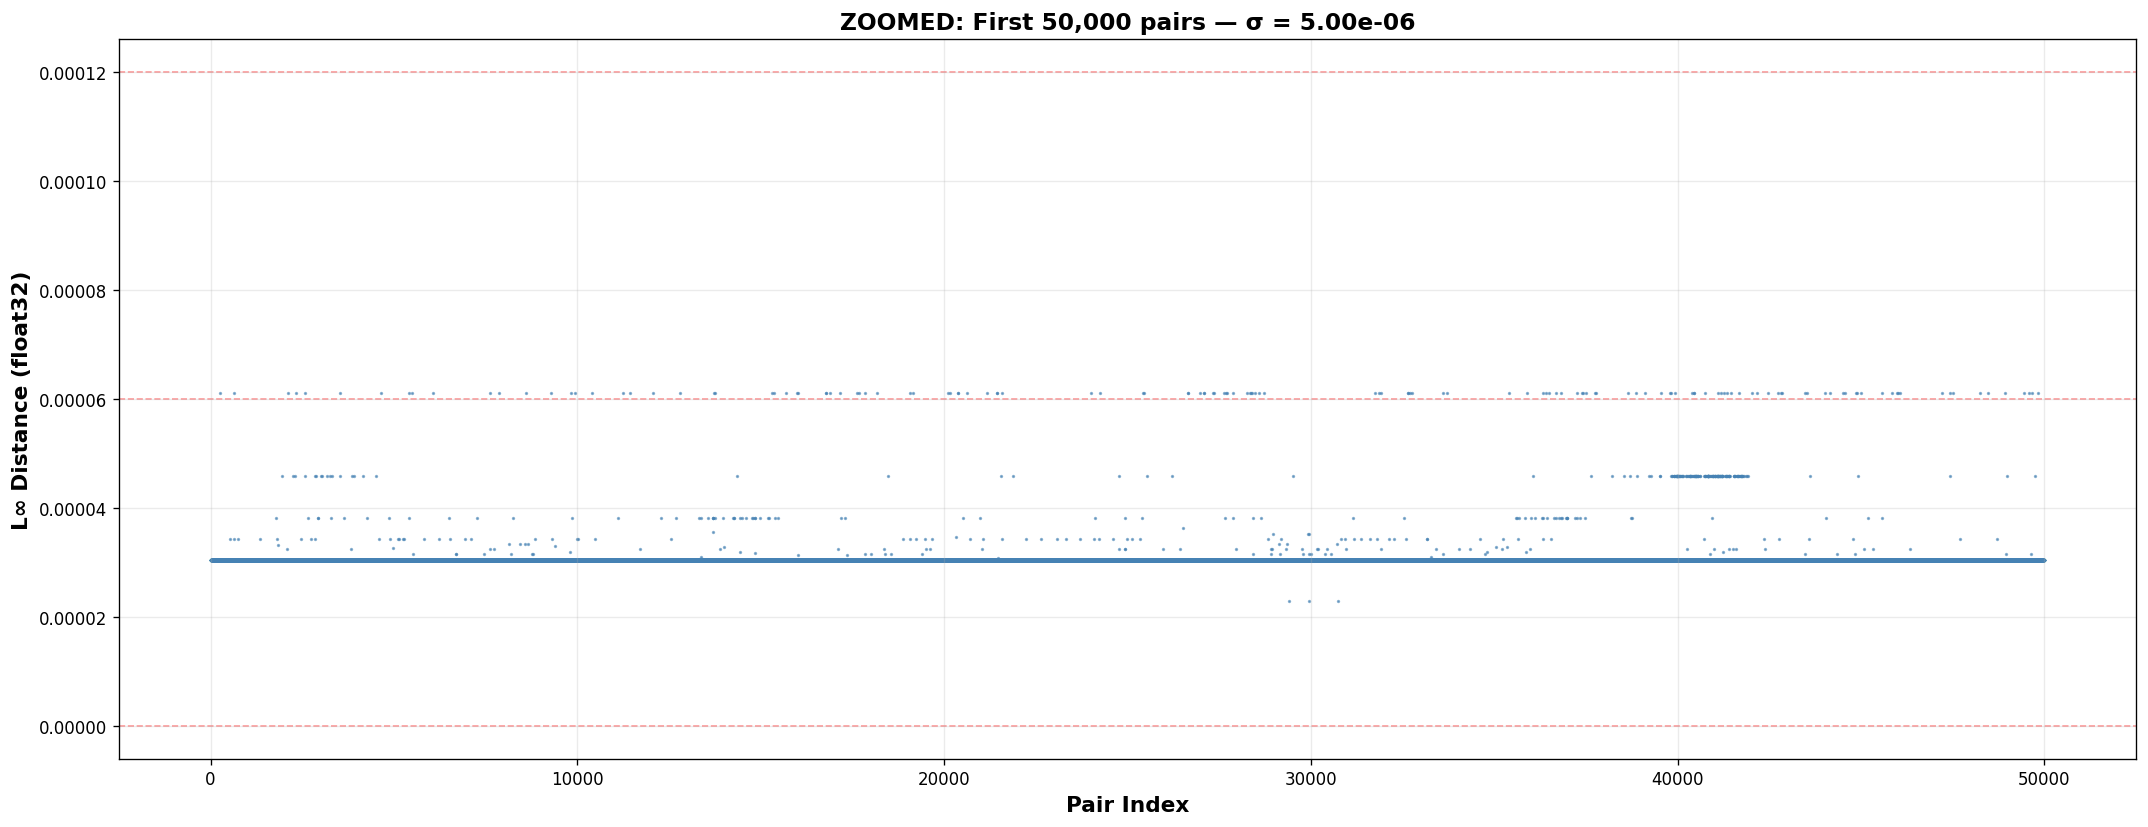


✓ Zoomed scatter complete


In [7]:
# Zoom in on a subset to see finer structure
zoom_range = 50000  # First 50k pairs

fig, ax = plt.subplots(figsize=(18, 7), dpi=120)

x_zoom = x_indices[:zoom_range]
y_zoom = pairwise_linf[:zoom_range]

ax.scatter(x_zoom, y_zoom, s=1.0, alpha=0.6, color='steelblue', rasterized=True)

# Red stripe lines
for mult in range(0, int(y_zoom.max() / ulp) + 2):
    ax.axhline(mult * ulp, color='red', linestyle='--', alpha=0.4, linewidth=1.0, zorder=1)

ax.set_xlabel('Pair Index', fontsize=13, fontweight='bold')
ax.set_ylabel('L∞ Distance (float32)', fontsize=13, fontweight='bold')
ax.set_title(f'ZOOMED: First {zoom_range:,} pairs — σ = {SIGMA:.2e}', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

print("\n✓ Zoomed scatter complete")

## Interpretation

**If you see horizontal stripes:**
- The bfloat16 quantization creates a discrete lattice
- Pairwise distances are restricted to multiples of the ULP
- **Ice hypercube confirmed** ✓

**If you see a continuous cloud:**
- No lattice structure
- Distances are smooth/continuous
- **Snow hyperball** (soft cluster)

**If you see both:**
- Some dimensions quantized, others continuous
- Partial lattice structure